On rajoute les données meteo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import cm
from matplotlib.colors import ListedColormap

from sklearn.ensemble import GradientBoostingRegressor

In [2]:
stations_debit = pd.read_csv("../Data/Base/Stations_Debit.csv")
liste_stations_debit = list(stations_debit["Code station"])

mesures_train_X = pd.read_csv("../Data/Base/Mesures_Train_X.csv")
mesures_train_X["Date"] = pd.to_datetime(mesures_train_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_train_Y = pd.read_csv("../Data/Base/Mesures_Train_Y.csv")
mesures_train_Y["Date"] = pd.to_datetime(mesures_train_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

train_split_X = pd.read_csv("../Data/Base/Index_CV_X.csv")
train_split_Y = pd.read_csv("../Data/Base/Index_CV_Y.csv")

mesures_test_X = pd.read_csv("../Data/Base/Mesures_Test_X.csv")
mesures_test_X["Date"] = pd.to_datetime(mesures_test_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_test_Y = pd.read_csv("../Data/Base/Mesures_Test_Y.csv")
mesures_test_Y["Date"] = pd.to_datetime(mesures_test_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

In [3]:
stations_meteo = pd.read_csv("../Data/Base/Stations_Meteo.csv")
liste_stations_meteo = list(stations_meteo["ID"].apply(lambda x: str(x).rjust(5, "0")))
colonnes_meteo = ["Pression", "Vent_Nord", "Vent_Est", "Vitesse_vent", "Temperature", "Humidite", "Precipitations"]
tempo = []
for code in liste_stations_meteo:
    tempo += [tp + "_" + code for tp in colonnes_meteo]
colonnes_meteo_stations = tempo

In [4]:
%run Eval_fcts.py
%run Standardize_fcts.py

In [5]:
%run Regression_GAM_Gamma.py

# Val croisée

In [6]:
n_knots = 10
lr_grid = [1, 3, 10, 30, 100, 300, 1000]
max_lag = 7

In [7]:
for curr_lr in lr_grid:
    for curr_lag in tqdm(range(min_lag,max_lag+1)):
        cv_scores_RMSE_standard = pd.DataFrame({"Code station": liste_stations_debit})
        cv_scores_MAE_standard = pd.DataFrame({"Code station": liste_stations_debit})
        cv_scores_R2_standard = pd.DataFrame({"Code station": liste_stations_debit})

        cv_scores_RMSE = pd.DataFrame({"Code station": liste_stations_debit})
        cv_scores_MAE = pd.DataFrame({"Code station": liste_stations_debit})
        cv_scores_R2 = pd.DataFrame({"Code station": liste_stations_debit})

        for curr_split in range(9):

            # Donnees
            curr_train_X = mesures_train_X[train_split_X["Train_" + str(curr_split)]]
            curr_train_Y = mesures_train_Y[train_split_Y["Train_" + str(curr_split)]]
            curr_test_X = mesures_train_X[train_split_X["Test_" + str(curr_split)]]
            curr_test_Y = mesures_train_Y[train_split_Y["Test_" + str(curr_split)]]
            liste_dates = curr_test_Y["Date"]

            curr_train_X_mean = curr_train_X[liste_stations_debit + colonnes_meteo_stations].mean()
            for code in liste_stations_debit:
                curr_train_X_mean[code] = 0
            curr_train_X_std = curr_train_X[liste_stations_debit + colonnes_meteo_stations].std()
            curr_train_X_standard = fct_Standardize(curr_train_X, curr_train_X_mean,
                                                    curr_train_X_std, liste_stations_debit + colonnes_meteo_stations)
            curr_train_X_standard["Date"] = curr_train_X["Date"]
            #GAM
            spline_fit = fct_Regression_SplineGamma_fit(curr_train_X_standard, liste_stations_debit, n_knots)
            curr_train_X_standard_residus = fct_Regression_SplineGamma_residus(spline_fit, 
                                                                               curr_train_X_standard, 
                                                                               liste_stations_debit)
            curr_train_X_standard_residus = pd.concat([curr_train_X_standard_residus, 
                                                          curr_train_X_standard[colonnes_meteo_stations]],
                                                         axis = 1)
            
             # Ajout AR
            colonnes_reg = colonnes_meteo_stations
            for i in range(curr_lag+1):
                variable = curr_train_X_standard_residus[liste_stations_debit].shift(i+7)
                variable.columns = [code+"_"+str(i) for code in liste_stations_debit]
                curr_train_X_standard_residus = pd.concat([curr_train_X_standard_residus, variable], axis = 1)
                colonnes_reg = colonnes_reg + [code+"_"+str(i) for code in liste_stations_debit]
            curr_train_X_standard_residus = curr_train_X_standard_residus[(7+curr_lag):]
            
            curr_test_X_standard =fct_Standardize(curr_test_X, curr_train_X_mean,
                                                  curr_train_X_std, liste_stations_debit + colonnes_meteo_stations)
            curr_test_X_standard["Date"] = curr_test_X["Date"].values
            curr_test_X_standard_residus = fct_Regression_SplineGamma_residus(spline_fit,
                                                                              curr_test_X_standard, 
                                                                              liste_stations_debit)
            curr_test_X_standard_residus = pd.concat([curr_test_X_standard_residus, 
                                                      curr_test_X_standard[colonnes_meteo_stations]],
                                                     axis = 1)
            # Ajout variables AR
            for i in range(curr_lag+1):
                variable = curr_test_X_standard_residus[liste_stations_debit].shift(i+7)
                variable.columns = [code+"_"+str(i) for code in liste_stations_debit]
                curr_test_X_standard_residus = pd.concat([curr_test_X_standard_residus, variable], axis = 1)
            curr_test_X_standard_residus = curr_test_X_standard_residus[(7+curr_lag):]
            
            curr_test_Y_standard = fct_Standardize(curr_test_Y, curr_train_X_mean,
                                                    curr_train_X_std, liste_stations_debit)
            curr_test_Y_standard["Date"] = curr_test_Y["Date"]

            curr_RMSE_standard = []
            curr_MAE_standard = []
            curr_R2_standard = []
            curr_RMSE = []
            curr_MAE = []
            curr_R2 = []
            
            for code in liste_stations_debit:

                # Entrainement
                model = GradientBoostingRegressor(learning_rate = curr_lr/1000)
                model.fit(X = curr_train_X_standard_residus[colonnes_reg],
                      y = curr_train_X_standard_residus[code])

                # Predictions Standard
                predictions_Y_standard_residus = model.predict(curr_test_X_standard_residus[colonnes_reg])
                predictions_Y_standard_residus = pd.DataFrame(predictions_Y_standard_residus, columns=[code])
                predictions_Y_standard_residus["Date"] = curr_test_X_standard_residus["Date"].values
                # Filtre sur les dates
                resultat = pd.DataFrame()
                for curr_date in liste_dates:
                    resultat = pd.concat([resultat, predictions_Y_standard_residus[predictions_Y_standard_residus["Date"] == curr_date]])
                resultat = resultat.sort_values(by = "Date")
                predictions_Y_standard_residus = resultat.copy()
                # On rajoute la compo saisonnalité
                predictions_Y_standard_saisonnalite = fct_Regression_SplineGamma_predict(spline_fit, liste_dates, [code])
                predictions_Y_standard = predictions_Y_standard_residus[["Date"]].copy()
                predictions_Y_standard[code] = predictions_Y_standard_residus[code].values + predictions_Y_standard_saisonnalite[code].values

                # Scores standards
                curr_RMSE_standard.append(fct_RMSE(curr_test_Y_standard, predictions_Y_standard, [code])["RMSE"][0])
                curr_MAE_standard.append(fct_MAE(curr_test_Y_standard, predictions_Y_standard, [code])["MAE"][0])
                curr_R2_standard.append(fct_R2(curr_test_Y_standard, predictions_Y_standard, [code])["R2"][0])
                # Score
                predictions_Y = fct_StandardizeInverse(predictions_Y_standard, 
                                                       curr_train_X_mean, curr_train_X_std, 
                                                       [code])
                predictions_Y["Date"] = predictions_Y_standard["Date"].values
                curr_RMSE.append(fct_RMSE(curr_test_Y, predictions_Y, [code])["RMSE"][0])
                curr_MAE.append(fct_MAE(curr_test_Y, predictions_Y, [code])["MAE"][0])
                curr_R2.append(fct_R2(curr_test_Y, predictions_Y, [code])["R2"][0])

            # On rassemble
            cv_scores_RMSE_standard["Split_" + str(curr_split)] = curr_RMSE_standard
            cv_scores_MAE_standard["Split_" + str(curr_split)] = curr_MAE_standard
            cv_scores_R2_standard["Split_" + str(curr_split)] = curr_R2_standard

            cv_scores_RMSE["Split_" + str(curr_split)] = curr_RMSE
            cv_scores_MAE["Split_" + str(curr_split)] = curr_MAE
            cv_scores_R2["Split_" + str(curr_split)] = curr_R2

        # Calcul des scores moyens du split
        cv_moyen_RMSE_standard = []
        cv_moyen_MAE_standard = []
        cv_moyen_R2_standard = []
        cv_moyen_RMSE = []
        cv_moyen_MAE = []
        cv_moyen_R2 = []

        for code in liste_stations_debit:
            score_RMSE = np.mean(cv_scores_RMSE_standard[cv_scores_RMSE_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_RMSE_standard.append(score_RMSE)
            score_MAE = np.mean(cv_scores_MAE_standard[cv_scores_MAE_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_MAE_standard.append(score_MAE)
            score_R2 = np.mean(cv_scores_R2_standard[cv_scores_R2_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_R2_standard.append(score_R2)
            score_RMSE = np.mean(cv_scores_RMSE[cv_scores_RMSE["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_RMSE.append(score_RMSE)
            score_MAE = np.mean(cv_scores_MAE[cv_scores_MAE["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_MAE.append(score_MAE)
            score_R2 = np.mean(cv_scores_R2[cv_scores_R2["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_R2.append(score_R2)

        cv_scores_RMSE_standard["Moyenne"] = cv_moyen_RMSE_standard
        cv_scores_RMSE_standard.to_csv("../Data/GAMGradientBoostingAR/CV_RMSE_standard_" + str(curr_lr) + "_" + str(curr_lag) + ".csv",
                              index=False)
        cv_scores_MAE_standard["Moyenne"] = cv_moyen_MAE_standard
        cv_scores_MAE_standard.to_csv("../Data/GAMGradientBoostingAR/CV_MAE_standard_" + str(curr_lr) + "_" + str(curr_lag) + ".csv",
                              index=False)
        cv_scores_R2_standard["Moyenne"] = cv_moyen_R2_standard
        cv_scores_R2_standard.to_csv("../Data/GAMGradientBoostingAR/CV_R2_standard_" + str(curr_lr) + "_" + str(curr_lag) + ".csv",
                              index=False)
        cv_scores_RMSE["Moyenne"] = cv_moyen_RMSE
        cv_scores_RMSE.to_csv("../Data/GAMGradientBoostingAR/CV_RMSE_" + str(curr_lr) + "_" + str(curr_lag) + ".csv",
                              index=False)
        cv_scores_MAE["Moyenne"] = cv_moyen_MAE
        cv_scores_MAE.to_csv("../Data/GAMGradientBoostingAR/CV_MAE_" + str(curr_lr) + "_" + str(curr_lag) + ".csv",
                              index=False)
        cv_scores_R2["Moyenne"] = cv_moyen_R2
        cv_scores_R2.to_csv("../Data/GAMGradientBoostingAR/CV_R2_" + str(curr_lr) + "_" + str(curr_lag) + ".csv",
                              index=False)


100%|██████████| 4/4 [9:40:11<00:00, 8702.89s/it]   


In [12]:
colonnes_meteo_stations

['Pression_07005',
 'Vent_Nord_07005',
 'Vent_Est_07005',
 'Vitesse_vent_07005',
 'Temperature_07005',
 'Humidite_07005',
 'Precipitations_07005',
 'Pression_07015',
 'Vent_Nord_07015',
 'Vent_Est_07015',
 'Vitesse_vent_07015',
 'Temperature_07015',
 'Humidite_07015',
 'Precipitations_07015',
 'Pression_07027',
 'Vent_Nord_07027',
 'Vent_Est_07027',
 'Vitesse_vent_07027',
 'Temperature_07027',
 'Humidite_07027',
 'Precipitations_07027',
 'Pression_07037',
 'Vent_Nord_07037',
 'Vent_Est_07037',
 'Vitesse_vent_07037',
 'Temperature_07037',
 'Humidite_07037',
 'Precipitations_07037',
 'Pression_07110',
 'Vent_Nord_07110',
 'Vent_Est_07110',
 'Vitesse_vent_07110',
 'Temperature_07110',
 'Humidite_07110',
 'Precipitations_07110',
 'Pression_07117',
 'Vent_Nord_07117',
 'Vent_Est_07117',
 'Vitesse_vent_07117',
 'Temperature_07117',
 'Humidite_07117',
 'Precipitations_07117',
 'Pression_07130',
 'Vent_Nord_07130',
 'Vent_Est_07130',
 'Vitesse_vent_07130',
 'Temperature_07130',
 'Humidite_0713

## Selection

In [22]:
n_cours_eau = 3
cours_eau = list(np.unique(stations_debit["Cours eau"]))
cours_eau_cmap = cm.get_cmap(ListedColormap(["red", "green", "blue"]))
cours_eau_couleur = pd.DataFrame({"Cours eau": cours_eau, "Index": range(n_cours_eau), "Couleur": ["red", "green", "blue"]})
cours_eau_couleur

Cours eau  Index Couleur
0   Garonne      0     red
1     Loire      1   green
2     Seine      2    blue

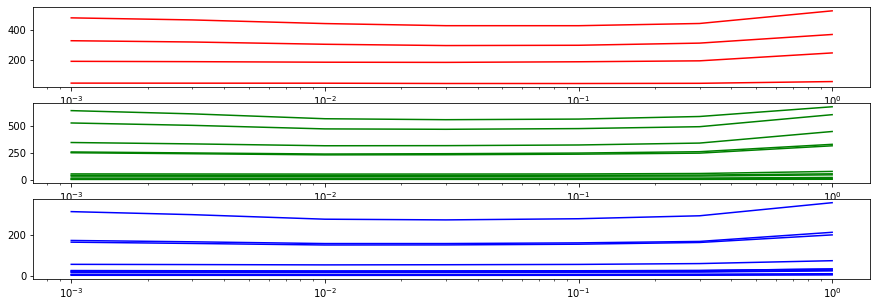

In [26]:
cv_moyen = pd.DataFrame()

for curr_lr in lr_grid:
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GradientBoosting_Meteo/CV_RMSE_lr_" + str(curr_lr) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["lr"] = curr_lr/1000
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["lr"], cv_moyen[code],
                   color = cours_eau_cmap(i))
        axs[i].set_xscale("log")
plt.show()

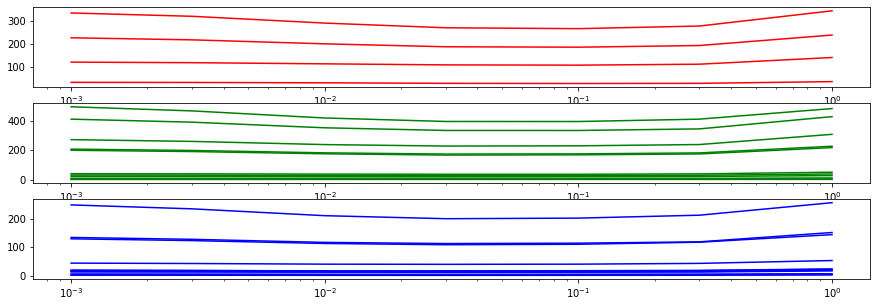

In [27]:
cv_moyen = pd.DataFrame()

for curr_lr in lr_grid:
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GradientBoosting_Meteo/CV_MAE_lr_" + str(curr_lr) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["lr"] = curr_lr/1000
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["lr"], cv_moyen[code],
                   color = cours_eau_cmap(i))
        axs[i].set_xscale("log")
plt.show()

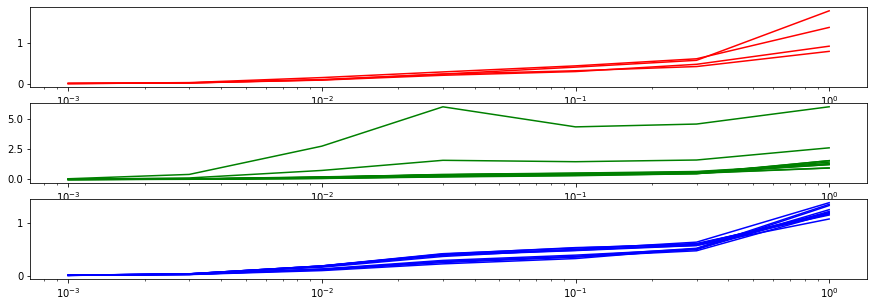

In [28]:
cv_moyen = pd.DataFrame()

for curr_lr in lr_grid:
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GradientBoosting_Meteo/CV_R2_lr_" + str(curr_lr) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["lr"] = curr_lr/1000
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["lr"], cv_moyen[code],
                   color = cours_eau_cmap(i))
        axs[i].set_xscale("log")
plt.show()

## Standard

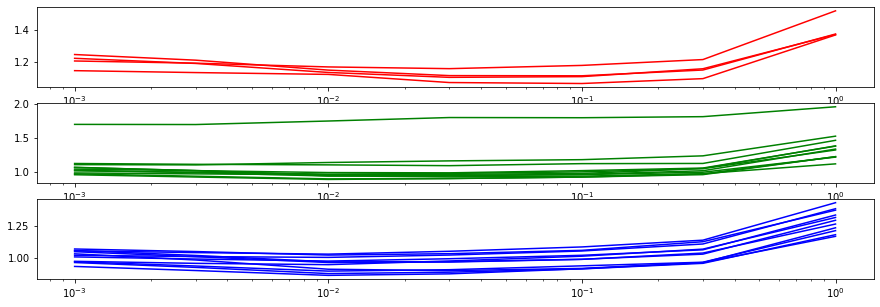

In [29]:
cv_moyen = pd.DataFrame()

for curr_lr in lr_grid:
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GradientBoosting_Meteo/CV_RMSE_standard_lr_" + str(curr_lr) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["lr"] = curr_lr/1000
 + ".csv")    cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["lr"], cv_moyen[code],
                   color = cours_eau_cmap(i))
        axs[i].set_xscale("log")
plt.show()

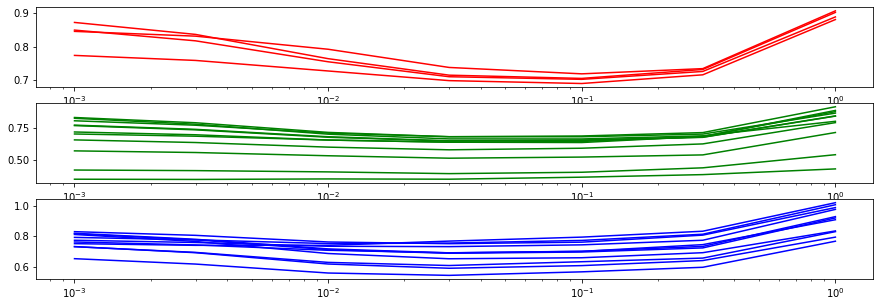

In [30]:
cv_moyen = pd.DataFrame()

for curr_lr in lr_grid:
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GradientBoosting_Meteo/CV_MAE_standard_lr_" + str(curr_lr) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["lr"] = curr_lr/1000
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["lr"], cv_moyen[code],
                   color = cours_eau_cmap(i))
        axs[i].set_xscale("log")
plt.show()

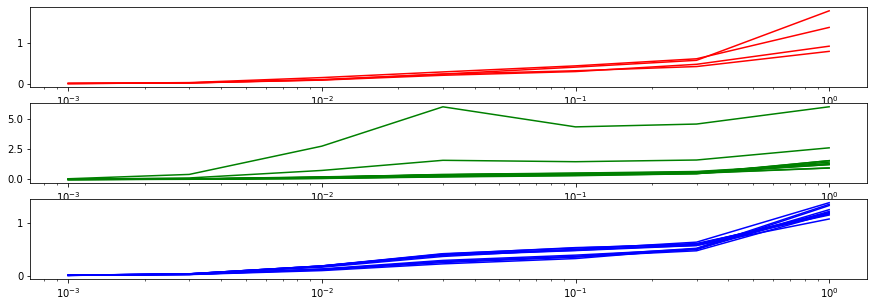

In [31]:
cv_moyen = pd.DataFrame()

for curr_lr in lr_grid:
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GradientBoosting_Meteo/CV_R2_standard_lr_" + str(curr_lr) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["lr"] = curr_lr/1000
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["lr"], cv_moyen[code],
                   color = cours_eau_cmap(i))
        axs[i].set_xscale("log")
plt.show()

## Moyen

In [9]:
cv_moyen = pd.DataFrame()

for curr_lag in range(max_lag+1):
    for curr_lr in lr_grid:
        curr_moyen = {} 
        cv_scores = pd.read_csv("../Data/GAMGradientBoostingAR/CV_RMSE_standard_" + str(curr_lr) + "_" + str(curr_lag) + ".csv")
        for code in liste_stations_debit:
            curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
        curr_moyen = pd.DataFrame(curr_moyen)
        curr_moyen["lr"] = curr_lr/1000
        curr_moyen["Lags"] = curr_lag
        cv_moyen = pd.concat([cv_moyen, curr_moyen])

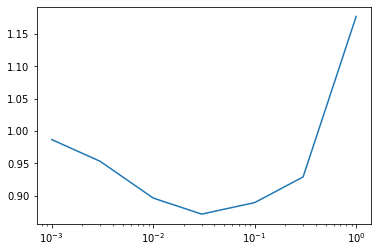

In [11]:
plt.plot(cv_moyen.groupby("lr").mean().index, cv_moyen.groupby("lr").mean()[liste_stations_debit].mean(axis = 1).values)
plt.xscale("log")
plt.savefig("../Data/Figures/GAMBoostAR/GAMBoostAR_RMSE_lr.png")

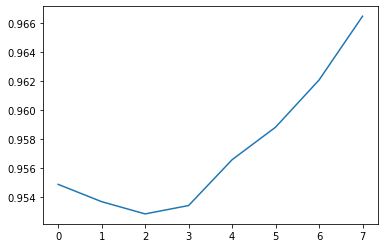

In [13]:
plt.plot(cv_moyen.groupby("Lags").mean().index, cv_moyen.groupby("Lags").mean()[liste_stations_debit].mean(axis = 1).values)
plt.savefig("../Data/Figures/GAMBoostAR/GAMBoostAR_RMSE_AR.png")

In [14]:
cv_moyen = pd.DataFrame()

for curr_lag in range(max_lag+1):
    for curr_lr in lr_grid:
        curr_moyen = {} 
        cv_scores = pd.read_csv("../Data/GAMGradientBoostingAR/CV_MAE_standard_" + str(curr_lr) + "_" + str(curr_lag) + ".csv")
        for code in liste_stations_debit:
            curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
        curr_moyen = pd.DataFrame(curr_moyen)
        curr_moyen["lr"] = curr_lr/1000
        curr_moyen["Lags"] = curr_lag
        cv_moyen = pd.concat([cv_moyen, curr_moyen])

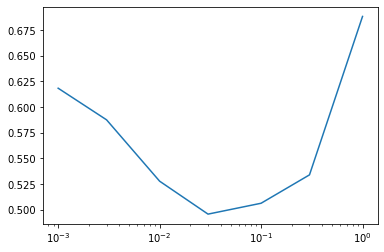

In [15]:
plt.plot(cv_moyen.groupby("lr").mean().index, cv_moyen.groupby("lr").mean()[liste_stations_debit].mean(axis = 1).values)
plt.xscale("log")
plt.savefig("../Data/Figures/GAMBoostAR/GAMBoostAR_MAE_lr.png")

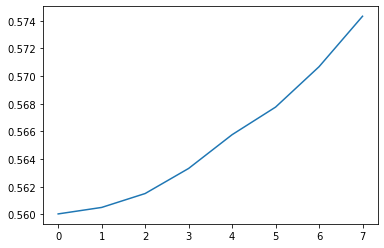

In [16]:
plt.plot(cv_moyen.groupby("Lags").mean().index, cv_moyen.groupby("Lags").mean()[liste_stations_debit].mean(axis = 1).values)
plt.savefig("../Data/Figures/GAMBoostAR/GAMBoostAR_MAE_AR.png")

In [17]:
cv_moyen = pd.DataFrame()

for curr_lag in range(max_lag+1):
    for curr_lr in lr_grid:
        curr_moyen = {} 
        cv_scores = pd.read_csv("../Data/GAMGradientBoostingAR/CV_R2_standard_" + str(curr_lr) + "_" + str(curr_lag) + ".csv")
        for code in liste_stations_debit:
            curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
        curr_moyen = pd.DataFrame(curr_moyen)
        curr_moyen["lr"] = curr_lr/1000
        curr_moyen["Lags"] = curr_lag
        cv_moyen = pd.concat([cv_moyen, curr_moyen])

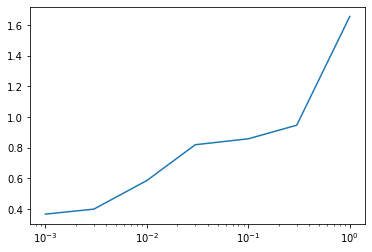

In [18]:
plt.plot(cv_moyen.groupby("lr").mean().index, cv_moyen.groupby("lr").mean()[liste_stations_debit].mean(axis = 1).values)
plt.xscale("log")
plt.savefig("../Data/Figures/GAMBoostAR/GAMBoostAR_R2_lr.png")

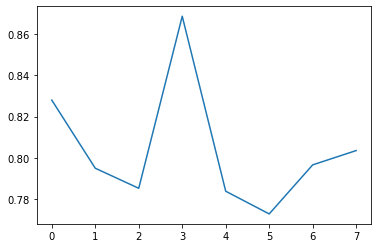

In [19]:
plt.plot(cv_moyen.groupby("Lags").mean().index, cv_moyen.groupby("Lags").mean()[liste_stations_debit].mean(axis = 1).values)
plt.savefig("../Data/Figures/GAMBoostAR/GAMBoostAR_R2_AR.png")

In [25]:
pd.read_csv("../Data/GAMGradientBoostingAR/CV_RMSE_standard_30_0.csv")["Moyenne"].mean()

0.8659299640943389

In [28]:
pd.read_csv("../Data/GAMGradientBoostingAR/CV_MAE_standard_30_0.csv")["Moyenne"].mean()

0.4882244050887976

In [30]:
pd.read_csv("../Data/GAMGradientBoostingAR/CV_R2_standard_30_0.csv")["Moyenne"].mean()

0.8338130258667693

# Test

In [5]:
lr = 3

In [6]:
# Donnees
mesures_train_X_mean = mesures_train_X[liste_stations_debit + colonnes_meteo_stations].mean()
mesures_train_X_std = mesures_train_X[liste_stations_debit + colonnes_meteo_stations].std()
mesures_train_X_standard = fct_Standardize(mesures_train_X, 
                                           mesures_train_X_mean, mesures_train_X_std, 
                                           liste_stations_debit + colonnes_meteo_stations)
mesures_train_X_standard["Date"] = mesures_train_X["Date"]

mesures_test_X_standard =fct_Standardize(mesures_test_X, mesures_train_X_mean, mesures_train_X_std, 
                                         liste_stations_debit + colonnes_meteo_stations)
mesures_test_X_standard["Date"] = mesures_test_X["Date"].values
mesures_test_Y_standard = fct_Standardize(mesures_test_Y, mesures_train_X_mean, mesures_train_X_std, 
                                          liste_stations_debit)
mesures_test_Y_standard["Date"] = mesures_test_Y["Date"]
liste_dates = mesures_test_Y["Date"]

In [57]:
scores_RMSE_standard = []
scores_MAE_standard = []
scores_R2_standard = []
scores_RMSE = []
scores_MAE = []
scores_R2 = []

predictions_test_Y_standard = mesures_test_Y[["Date"]]
predictions_test_Y = mesures_test_Y[["Date"]]

for code in tqdm(liste_stations_debit):
        # Entrainement
        model = GradientBoostingRegressor(learning_rate = lr)
        model.fit(X = mesures_train_X_standard[colonnes_meteo_stations],
                  y = mesures_train_X_standard[code])
        
        # Predictions Standard
        predictions_Y_standard = model.predict(mesures_test_X_standard[colonnes_meteo_stations])
        predictions_Y_standard = pd.DataFrame(predictions_Y_standard, columns=[code])
        predictions_Y_standard["Date"] = mesures_test_X_standard["Date"].values
        # Filtre sur les dates
        resultat = pd.DataFrame()
        for curr_date in liste_dates:
            resultat = pd.concat([resultat, predictions_Y_standard[predictions_Y_standard["Date"] == curr_date]])
        resultat = resultat.sort_values(by = "Date")
        predictions_Y_standard = resultat.copy()
        predictions_test_Y_standard = predictions_test_Y_standard.merge(predictions_Y_standard)
        
        predictions_Y = fct_StandardizeInverse(predictions_Y_standard, 
                                                   mesures_train_X_mean, mesures_train_X_std, 
                                                   [code])
        predictions_Y["Date"] = predictions_Y_standard["Date"].values
        predictions_test_Y = predictions_test_Y.merge(predictions_Y)
        
        # Scores standards
        scores_RMSE_standard.append(fct_RMSE(mesures_test_Y_standard, predictions_Y_standard, [code])["RMSE"][0])
        scores_MAE_standard.append(fct_MAE(mesures_test_Y_standard, predictions_Y_standard, [code])["MAE"][0])
        scores_R2_standard.append(fct_R2(mesures_test_Y_standard, predictions_Y_standard, [code])["R2"][0])
        # Score
        scores_RMSE.append(fct_RMSE(mesures_test_Y, predictions_Y, [code])["RMSE"][0])
        scores_MAE.append(fct_MAE(mesures_test_Y, predictions_Y, [code])["MAE"][0])
        scores_R2.append(fct_R2(mesures_test_Y, predictions_Y, [code])["R2"][0])        

100%|██████████| 26/26 [07:10<00:00, 16.57s/it]


In [59]:
test_scores = pd.DataFrame({"Code station": liste_stations_debit,
                            "RMSE": scores_RMSE,
                            "MAE": scores_MAE,
                            "R2": scores_R2})
test_scores.to_csv("../Data/GradientBoosting_Meteo/Test_scores.csv")
test_scores

Code station        RMSE         MAE        R2
0      O0200020   24.612995   19.043538  0.350588
1      O2620010  138.534150   88.040156  0.168696
2      O6140010  253.378798  162.184919  0.215427
3      O9000010  401.141717  242.696283  0.208476
4      K0030020    5.208422    1.336597  1.438025
5      K0100020    6.810508    3.124339  0.563935
6      K0260020   17.422607    8.078773  0.168320
7      K0550010   37.846574   20.625533  0.203431
8      K0690010   49.383321   27.860802  0.164431
9      K0910050   55.004239   34.726694  0.212028
10     K4180010  171.609457  138.718007  0.477128
11     K4350020  173.093251  139.677104  0.472524
12     K6830020  217.879068  171.319172  0.449673
13     L8000020  328.091090  247.222828  0.443636
14     M5300010  482.356139  333.905204  0.299612
15     H0100010    3.861465    2.722649  0.386773
16     H0100020    8.231763    6.150848  0.314491
17     H0400010   23.392538   16.739247  0.273703
18     H0400020   14.104094   10.694123  0.269329
19     H0800011   15.779643   11.882530  0.188152
20     H0800012    5.538400    4.089332  0.233178
21     H0810010   21.540175   16.368391  0.140922
22     H1700010   55.652982   39.762645  0.136741
23     H3930020  133.572586   99.437763  0.254438
24     H4340020  138.195914  102.554437  0.276345
25     H8100021  338.820537  232.271719  0.183276

In [60]:
test_scores_standard = pd.DataFrame({"Code station": liste_stations_debit,
                            "RMSE": scores_RMSE,
                            "MAE": scores_MAE,
                            "R2": scores_R2})
test_scores_standard.to_csv("../Data/GradientBoosting_Meteo/Test_scores_standard.csv")
test_scores_standard

Code station        RMSE         MAE        R2
0      O0200020   24.612995   19.043538  0.350588
1      O2620010  138.534150   88.040156  0.168696
2      O6140010  253.378798  162.184919  0.215427
3      O9000010  401.141717  242.696283  0.208476
4      K0030020    5.208422    1.336597  1.438025
5      K0100020    6.810508    3.124339  0.563935
6      K0260020   17.422607    8.078773  0.168320
7      K0550010   37.846574   20.625533  0.203431
8      K0690010   49.383321   27.860802  0.164431
9      K0910050   55.004239   34.726694  0.212028
10     K4180010  171.609457  138.718007  0.477128
11     K4350020  173.093251  139.677104  0.472524
12     K6830020  217.879068  171.319172  0.449673
13     L8000020  328.091090  247.222828  0.443636
14     M5300010  482.356139  333.905204  0.299612
15     H0100010    3.861465    2.722649  0.386773
16     H0100020    8.231763    6.150848  0.314491
17     H0400010   23.392538   16.739247  0.273703
18     H0400020   14.104094   10.694123  0.269329
19     H0800011   15.779643   11.882530  0.188152
20     H0800012    5.538400    4.089332  0.233178
21     H0810010   21.540175   16.368391  0.140922
22     H1700010   55.652982   39.762645  0.136741
23     H3930020  133.572586   99.437763  0.254438
24     H4340020  138.195914  102.554437  0.276345
25     H8100021  338.820537  232.271719  0.183276

In [62]:
test_scores_standard[["RMSE", "MAE", "R2"]].mean()

RMSE    120.040863
MAE      83.893601
R2        0.326664
dtype: float64

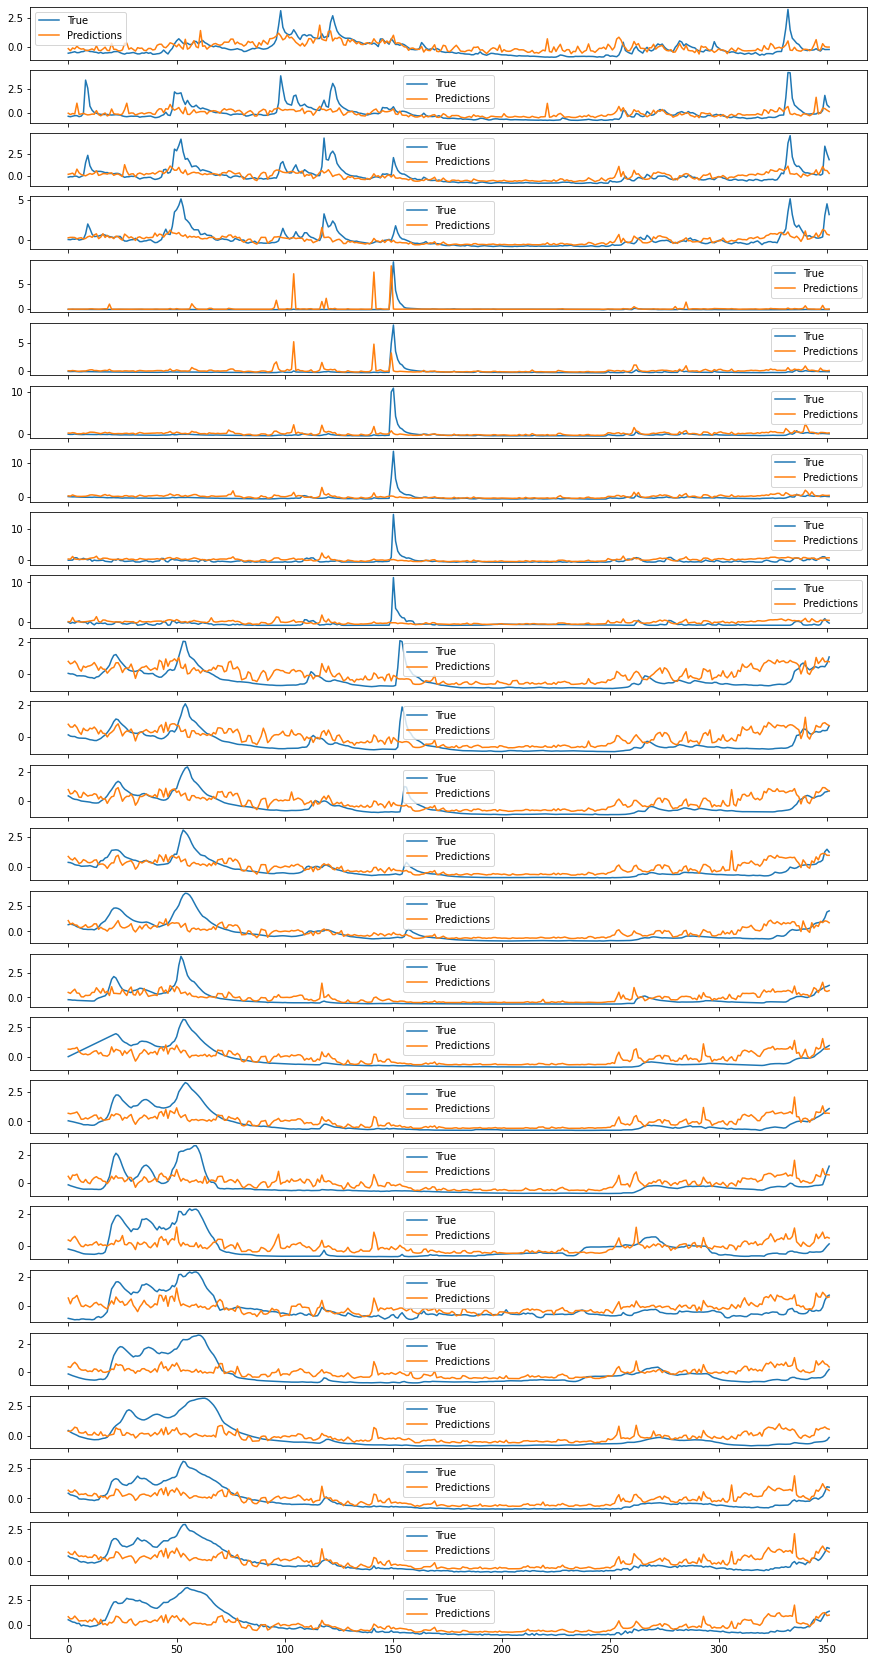

In [63]:
n_stations = len(liste_stations_debit)
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = liste_stations_debit[i]
    axs[i].plot(mesures_test_Y_standard[code], label = "True")
    axs[i].plot(predictions_test_Y_standard[code], label = "Predictions")
    axs[i].legend()

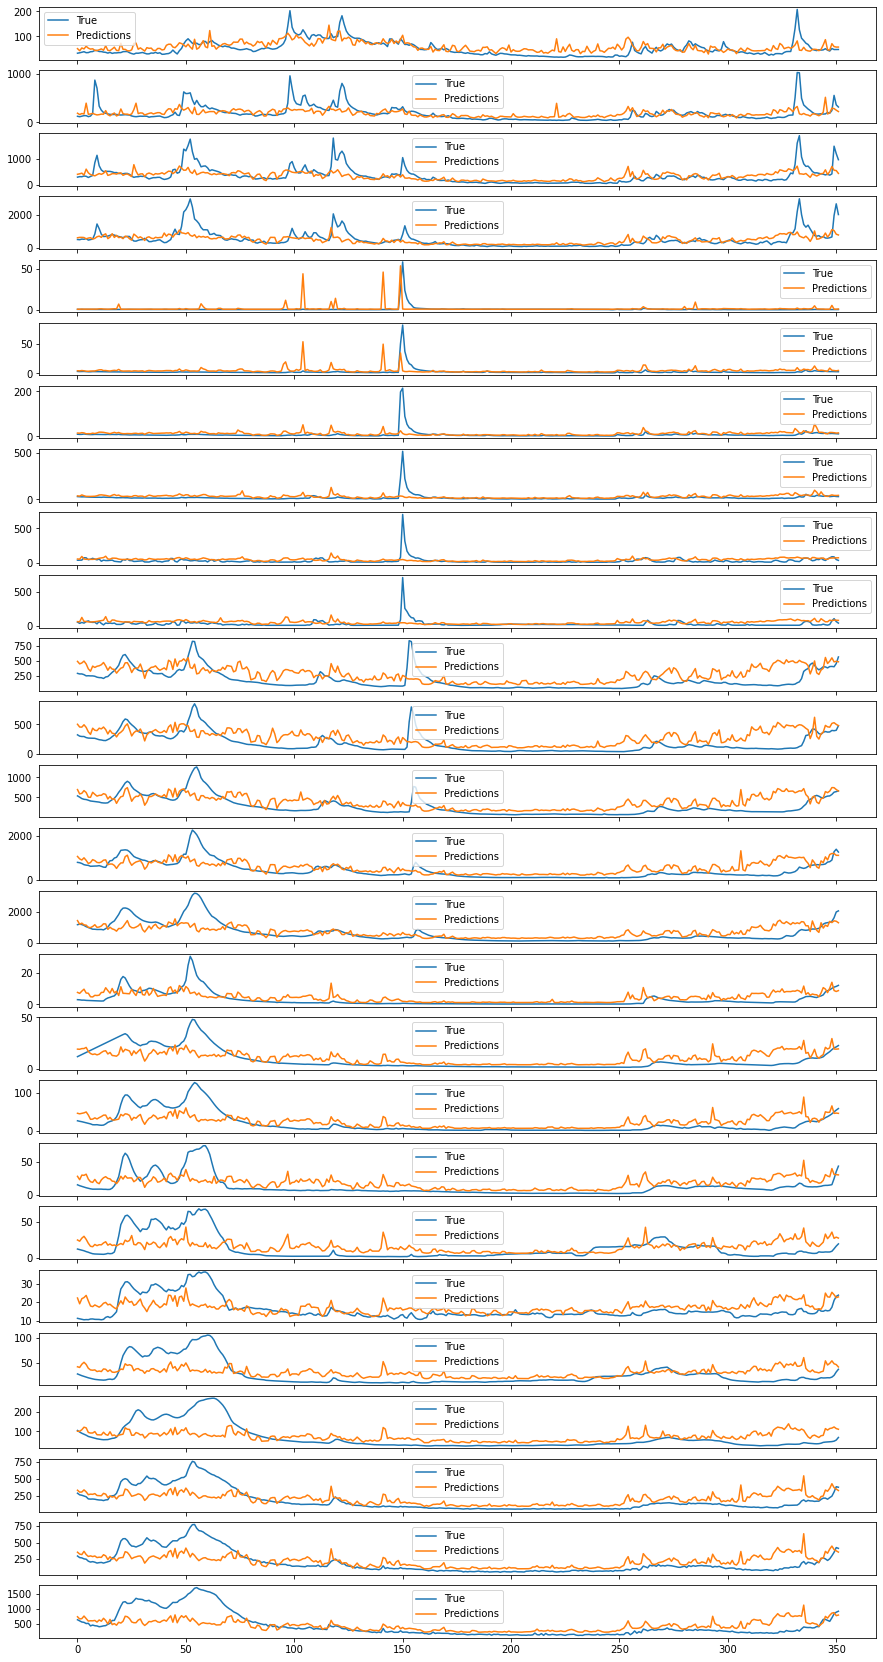

In [64]:
n_stations = len(liste_stations_debit)
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = liste_stations_debit[i]
    axs[i].plot(mesures_test_Y[code], label = "True")
    axs[i].plot(predictions_test_Y[code], label = "Predictions")
    axs[i].legend()